In [34]:
import earthpy.mask as em
import earthpy.plot as ep
import rioxarray as rxr
import numpy as np
from landsat_processing_utils import qa_pixel_interp_conserv_water, apply_array_func
from glob import glob
import os
from tqdm import tqdm

In [33]:
def cloud_interpolation(func, target_dir, savename = 'cl_interpolated.tif'):
    '''
    Conducts cloud interpolation on stacked landsat Level 1 products.
    NOTE: The final band of the Level 1 stack must be the QA_pixel band.    
    Products will be processed in sorted filename order. 
    
    func: The kind of cloud masking you'd like to do - this function should take in a 16-bit \
    QA_PIXEL value and return a bool indicating if it should be masked or not 
    filepath: folder containing all stacked raster files
    savename: filename of the final raster. By default will be saved in the target_dir
    
    Returns:
    A single rioxarray DataArray containing bands 1-11, with np.nan in areas that have been masked \
    according to the provided func
    '''
    data = []
    
    filepaths = glob(os.path.join(target_dir, '*TOA_crop_stacked.tif'))
    
    for filepath in filepaths:
        with rxr.open_rasterio(filepath, masked = True) as ds:
            data.append(ds)
        ds.close()
        
    current_scene = None

    for scene in data:
        # classify the QA raster using conservative cloud estimates
        unique_vals = np.unique(scene.sel(band = 11).astype(np.int32).data)
        masked_vals = apply_array_func(qa_pixel_interp_conserv_water, unique_vals)

        # masked vals contains a list of vals indicating clouds or water
        masked_vals = unique_vals[masked_vals]

        # turn all masked pixels into np.nan
        cloud_free = scene.loc[1:10,...].where(~scene.sel(band = 11).astype(np.int32).isin(masked_vals))
        
        # if this is the first map in the list, replace with cloud_free scene
        if current_scene is None:
            current_scene = cloud_free
        else:
            # if this is not the first dataarray in the list
            # find all values that are null, and replace them with whatever is in the current 
            # cloud_free dataarray.
            current_scene = current_scene.where(current_scene.notnull(), cloud_free)
    
    # Current nodata is nonetype
    current_scene = current_scene.rio.write_nodata(np.nan, inplace = True)
    
    # Change the long_name attribute
    current_scene.attrs['long_name'] = current_scene.attrs['long_name'][:-1] 
    
    current_scene.rio.to_raster(os.path.join(target_dir, savename))

In [35]:
# Create a cloud interpolated tif for all years
years = [i for i in range(2013, 2023)]

for year in tqdm(years):
    cloud_interpolation(qa_pixel_interp_conserv_water, 
                        target_dir = f'outputs/{year}',
                        savename = f'{year}_MASKED.tif')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


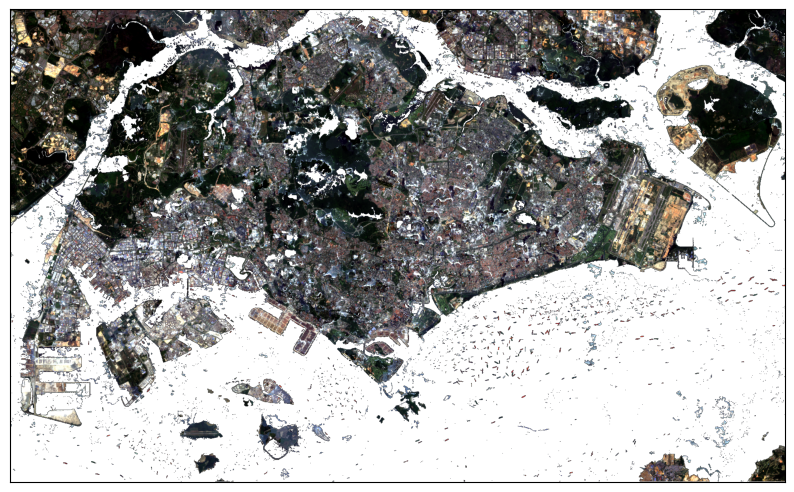

<Axes: >

In [36]:
test = rxr.open_rasterio('outputs/2022/2022_MASKED.tif')

ep.plot_rgb(test.data, rgb = (3,2,1), stretch = True)

In [4]:
data = []

filepaths = glob(os.path.join('outputs/2013', '*TOA_crop_stacked.tif'))

In [5]:
for filepath in filepaths:
    with rxr.open_rasterio(filepath, 
                            masked = True) as ds:
        data.append(ds)
        ds.close()

In [6]:
current_scene = None

for scene in data:
    # classify the QA raster using conservative cloud estimates
    unique_vals = np.unique(scene.sel(band = 11).astype(np.int32).data)
    masked_vals = apply_array_func(qa_pixel_interp_conserv_water, unique_vals)
    
    # masked vals contains a list of vals indicating clouds or water
    masked_vals = unique_vals[masked_vals]
    
    # turn all masked pixels into np.nan
    cloud_free = scene.loc[1:10,...].where(~scene.sel(band = 11).astype(np.int32).isin(masked_vals))
    
    if current_scene is None:
        current_scene = cloud_free
    else:
        # if this is not the first dataarray in the list
        current_scene = current_scene.where(current_scene.notnull(), cloud_free)

In [32]:
current_scene.attrs['long_name'][:-1] 

('Coastal',
 'Blue',
 'Green',
 'Red',
 'NIR',
 'SWIR-1',
 'SWIR-2',
 'Cirrus',
 'TIRS-1',
 'TIRS-2')

In [26]:
target_dir = 'outputs/2013'
suffix = 'MASKED.tif'
os.path.join(target_dir, suffix)

'outputs/2013\\MASKED.tif'

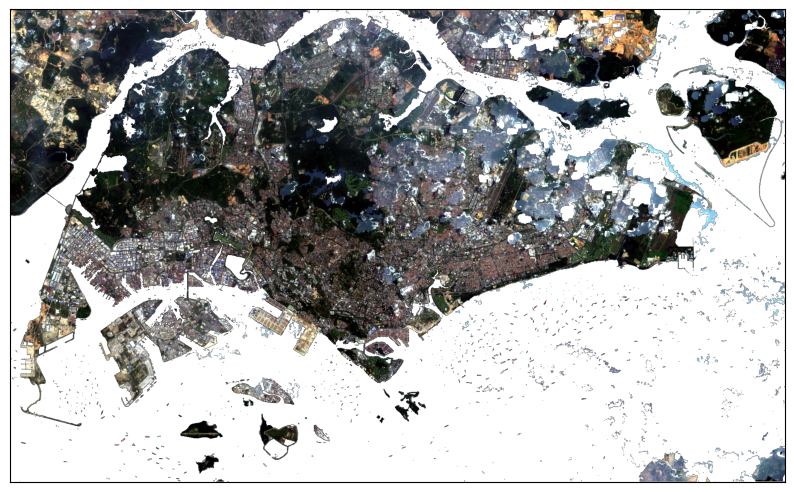

<Axes: >

In [74]:
ep.plot_rgb(current_scene.data, rgb = (3,2,1), stretch = True)

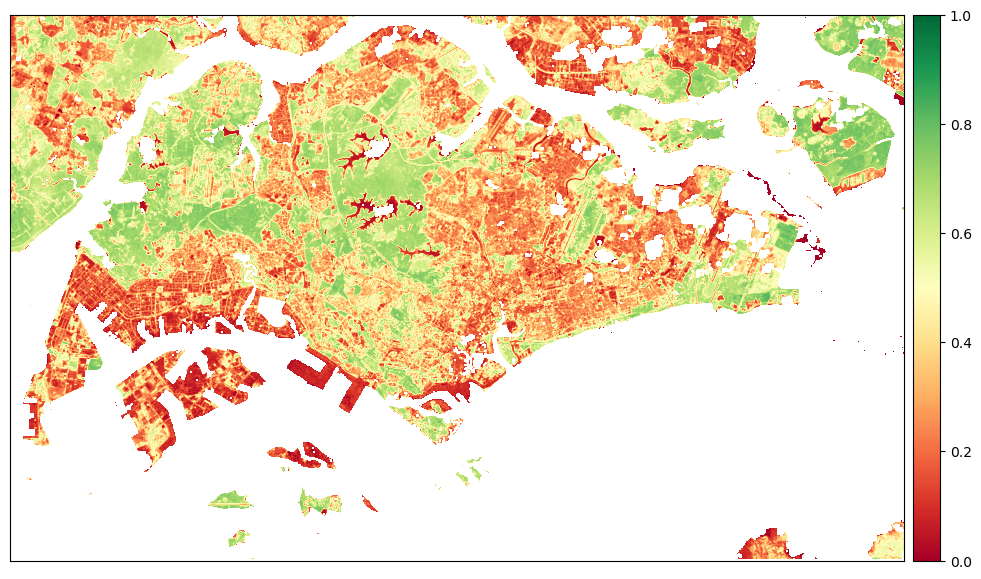

<Axes: >

In [85]:
# normalized difference vegetation index
ndvi = (current_scene[4] - current_scene[3]) / (current_scene[4] + current_scene[3])

ep.plot_bands(ndvi, cmap = 'RdYlGn', vmin = 0, vmax = 1)

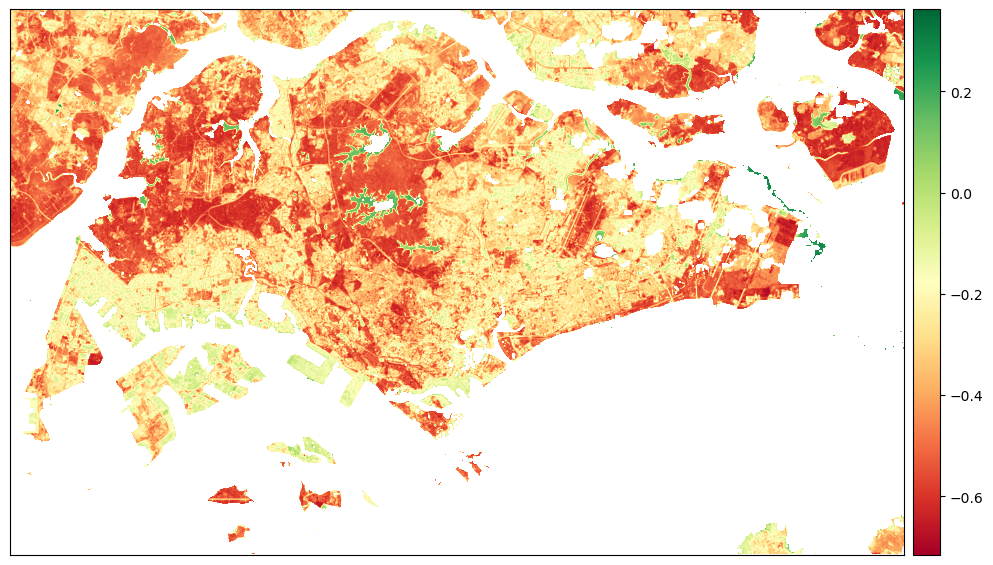

<Axes: >

In [90]:
# normalized difference water index
ndwi = (current_scene[2] - current_scene[4]) / (current_scene[2] + current_scene[4])

ep.plot_bands(ndwi, cmap = 'RdYlGn')

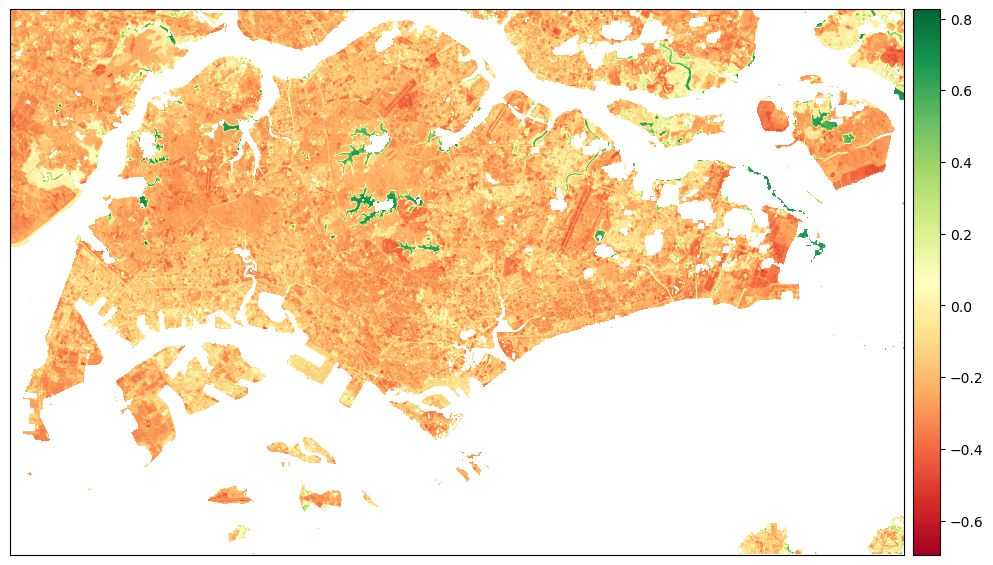

<Axes: >

In [91]:
# modified normalized difference water index
mndwi = (current_scene[2] - current_scene[5]) / (current_scene[2] + current_scene[5])

ep.plot_bands(mndwi, cmap = 'RdYlGn')

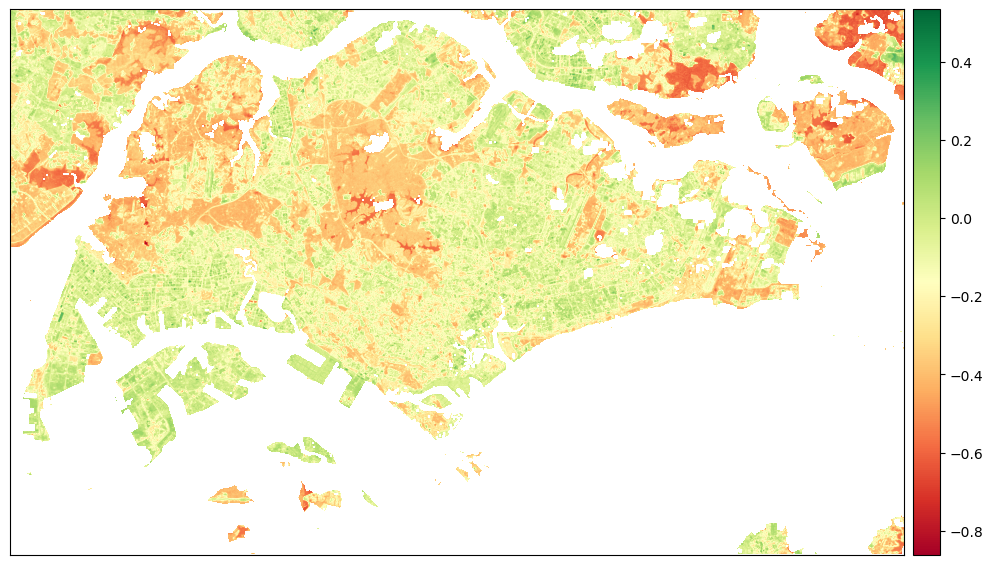

<Axes: >

In [88]:
# normalized difference builtup index
ndbi = (current_scene[5] - current_scene[4]) / (current_scene[5] + current_scene[4])

ep.plot_bands(ndbi, cmap = 'RdYlGn')

In [39]:
# classify the QA raster using conservative cloud estimates
unique_vals = np.unique(test.sel(band = 11).astype(np.int32).data)
masked_vals = apply_array_func(qa_pixel_interp_conserv_water, unique_vals)
masked_vals = unique_vals[masked_vals]

masked_vals

cloud_free = test.loc[1:10,...].where(~test.sel(band = 11).astype(np.int32).isin(masked_vals))

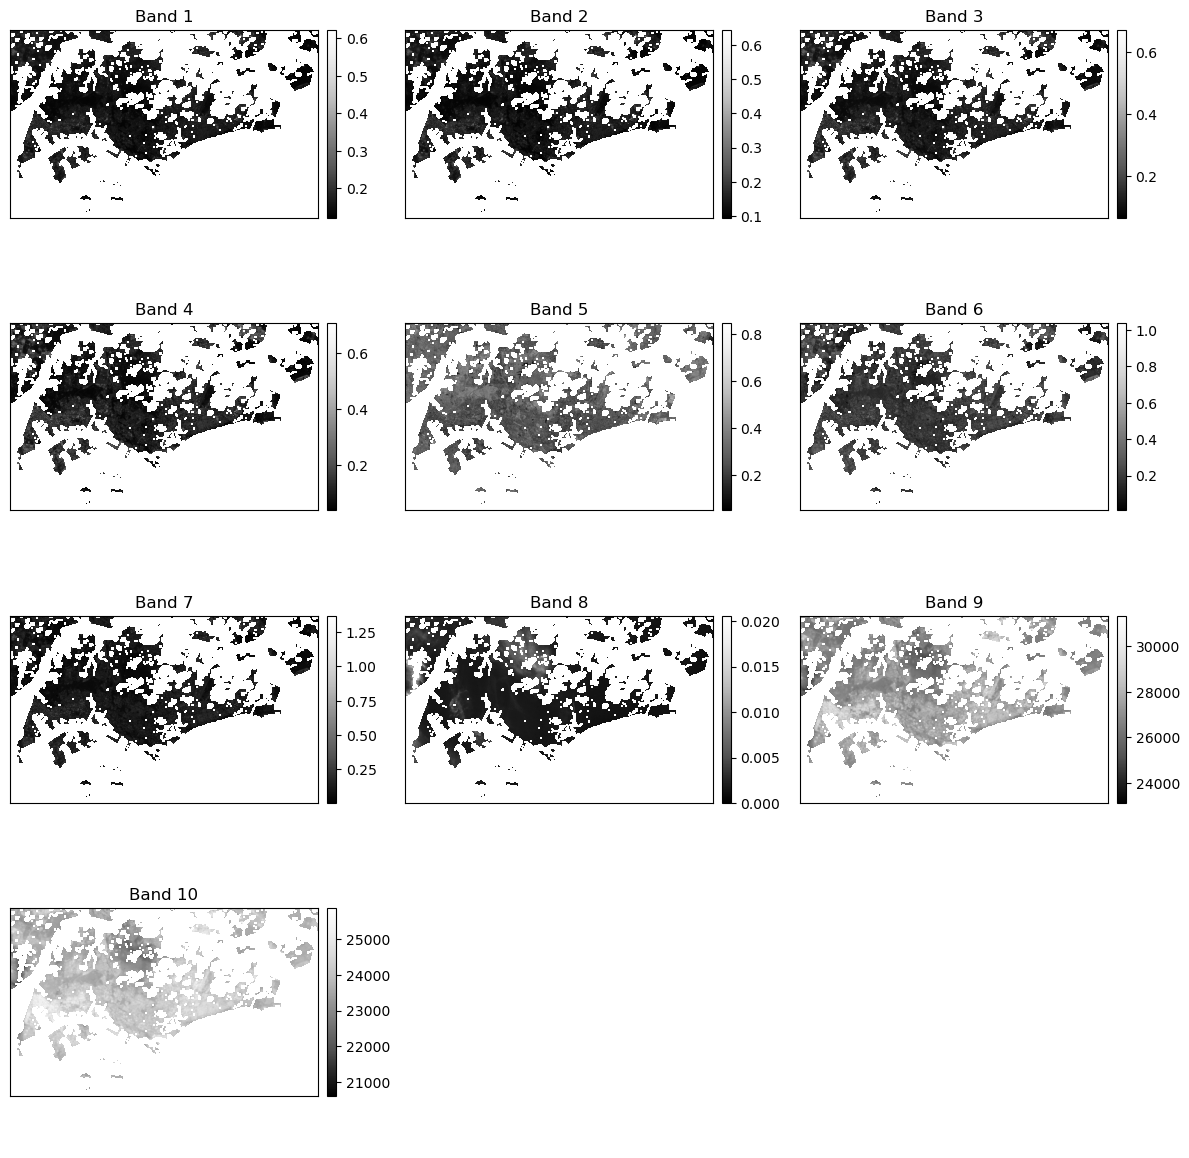

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [40]:
ep.plot_bands(cloud_free)

In [ ]:
cloud_free.where(np.nan, )

In [18]:
cloud_free = test.loc[1:10,...].where(~test.sel(band = 11).isin(full_mask))

cloud_free

<xarray.DataArray (band: 10, y: 1113, x: 1824)>
array([[[           nan, 2.07055003e-01, 2.12943038e-01, ...,
         3.91893998e-01, 3.67458655e-01, 3.97170583e-01],
        [           nan, 1.89481484e-01, 1.92493440e-01, ...,
         3.95879745e-01, 3.71738803e-01, 3.90671099e-01],
        [           nan, 1.85405153e-01, 1.82619659e-01, ...,
         3.92641326e-01, 3.76720986e-01, 3.89380261e-01],
        ...,
        [           nan, 1.43350997e-01, 1.44120971e-01, ...,
         6.23497577e-01, 6.45215366e-01, 6.43947174e-01],
        [           nan, 1.44211556e-01, 1.44256849e-01, ...,
         5.99900146e-01, 6.26758642e-01, 6.14484354e-01],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan, 1.91746113e-01, 1.97656794e-01, ...,
         3.83152532e-01, 3.57245179e-01, 3.89267029e-01],
        [           nan, 1.72564708e-01, 1.76301345e-01, ...,
         3.84896296e-01, 3.56769607e-01, 3.80027344e-01],
        [           nan, 1.69665983e-01, 1.63007975e-01, ...,
         3.80389685e-01, 3.67186899e-01, 3.85688916e-01],
...
        [           nan, 2.45950000e+04, 2.46200000e+04, ...,
         2.41360000e+04, 2.41390000e+04, 2.41460000e+04],
        [           nan, 2.45950000e+04, 2.46300000e+04, ...,
         2.41090000e+04, 2.41160000e+04, 2.41280000e+04],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan, 2.36770000e+04, 2.36450000e+04, ...,
         2.27470000e+04, 2.26960000e+04, 2.26660000e+04],
        [           nan, 2.36370000e+04, 2.36310000e+04, ...,
         2.27570000e+04, 2.27140000e+04, 2.26830000e+04],
        [           nan, 2.36160000e+04, 2.36470000e+04, ...,
         2.27750000e+04, 2.27400000e+04, 2.27040000e+04],
        ...,
        [           nan, 2.21980000e+04, 2.22000000e+04, ...,
         2.21930000e+04, 2.21990000e+04, 2.22130000e+04],
        [           nan, 2.21940000e+04, 2.21950000e+04, ...,
         2.21920000e+04, 2.22050000e+04, 2.22150000e+04],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 3.441e+05 3.442e+05 ... 3.988e+05 3.988e+05
  * y            (y) float64 1.632e+05 1.632e+05 ... 1.299e+05 1.299e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR-1', 'SWI...

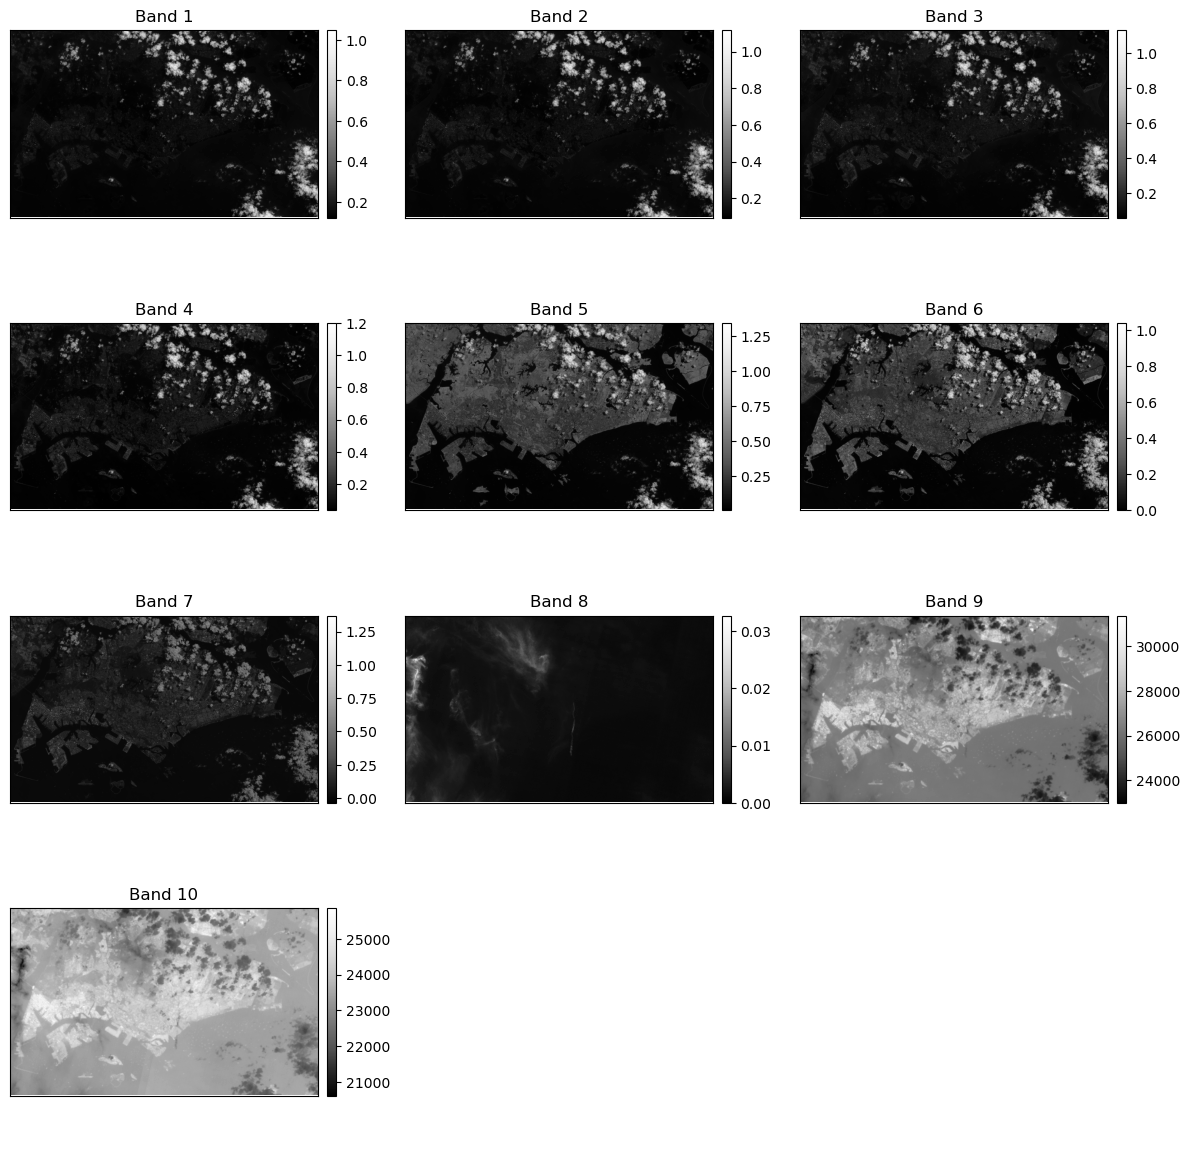

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [20]:
ep.plot_bands(cloud_free)

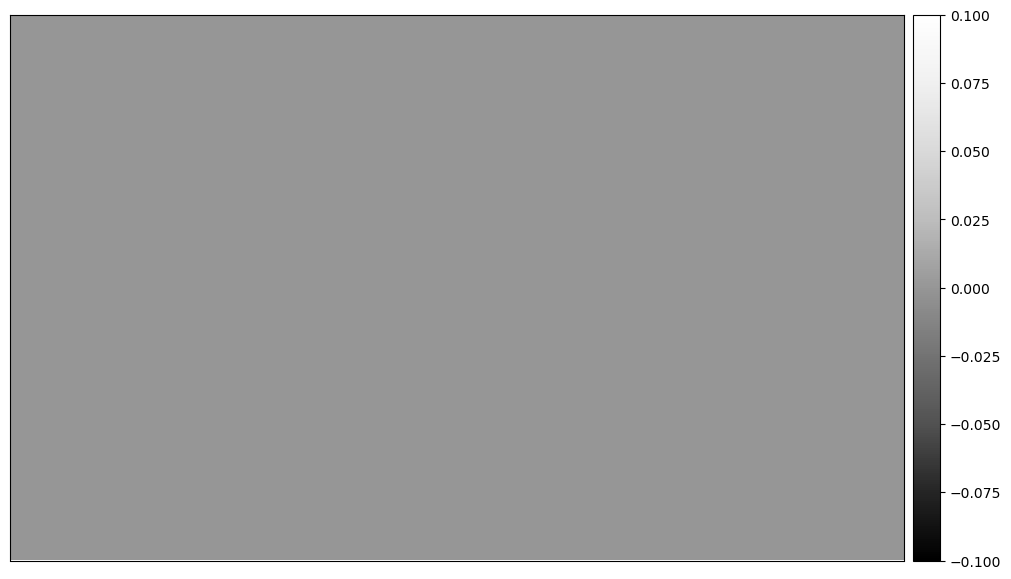

<Axes: >

In [28]:
ep.plot_bands(test.sel(band = 11).astype(np.int32).isin(full_mask))

In [2]:
qa_pixel_interp_conserv_water()

<function landsat_processing_utils.qa_pixel_interp_conserv_water(number)>